# How can we calculate a flux in Sherpa

This notebook is geared towards people who want to calculate the flux of a source for which they have an X-ray spectrum in PHA format. It is also aimed at people using Sherpa from CIAO - that is, they are used to the [Sherpa threads](https://cxc.cfa.harvard.edu/sherpa/threads/).

The presentation is done using a Python (aka Jupyter) notebook, and is broken down into the following sections:

  - How do I ...
   - calculate a flux?
   - generate erros?
  - 1. Introduction
   - 1.1 How to load Sherpa
   - 1.2 How to create a model
   - 1.3 Getting help
   - 1.4 What model instances have been created?
   - 1.5 The many ways of specifying a model expression
   - 1.6 Skip ahead
   - 1.7 How do I delete a model instance
   - 1.8 Evaluating a model
  - 2. Manually calculating the flux
  - 3. Setting up the data in Sherpa
  - 4. calculate_energy_flux
   - 4.1 Absorbed versus unabsorbed fluxes
  - 5. How about parameter errors?
   - 5.1 sample_photon_flux and sample_energy_flux
   - 5.2 correlated=True
   - 5.3 A note on clipping
   - 5.4 What errors are used?
   - 5.5 sample_flux
   - 5.6 sample_flux and unabsorbed fluxes
   - 5.7 sample_energy_flux versus sample_flux
  - 6. XSPEC's cflux model
  - 7. Calculating luminosities
   - 7.1 The K correction
   - 7.2 luminosity distance
   - 7.3 Putting it all together

---

# History

## CIAO 4.16

There have been no significant changes to the flux-calculation routines in this release, but there are several changes we do take advantage of:

- use the `sherpa.astro.charge_e` value for converting between keV and erg rather than a copy of this value (i.e. no more `KEV_TO_ERG = 1.60217653e-09`)
- the [group_counts](https://cxc.cfa.harvard.edu/sherpa/ahelp/group_counts.html) now defaults to only selecting the noticed data range, meaning we do not have to set the `tabStops` argument
- the new [set_rng](https://cxc.cfa.harvard.edu/sherpa/ahelp/set_rng.html) call is used to fix the random-number generator (so that repeated runs of this notebook will create the same output)
- CIAO 4.16 includes XSPEC version 12.13.1e and so now has access to the [xscglumin](https://cxc.cfa.harvard.edu/sherpa/ahelp/xscglumin.html) convolution model

## CIAO 4.14

The `sample_flux` command has seen a number of improvements so that it matches `sample_energy_flux`.

This release fixed a number of corner cases with filtering PHA data, and as part of that the `get_filter` output was changed to record the full energy range (previously it showed the mid-points for the start and end ranges: as the energy bins have a finite width, and are often grouped together the mid-point can make it harder to see the chosen range). This does not change the results of this notebook but may make small changes to your analysis.

The default `xschatter` setting of XSPEC models has been changed from 0 to 10, to match XSPEC, which may create more screen output when a model is evaluated.

## CIAO 4.13

Version 4.13 contained bug fixes and improvements to the `sample_energy_flux` and `sample_photon_flux` functions (the handling of the `samples` parameter was improved, the `model` and `clip` parameters were added, and the return value gained an extra column). It also adds support
for the XSPEC convolution models, which simplifies the `XSPEC's cflux model` section below compared to the CIAO 4.12.1 version.

The notebook integration of Sherpa was also improved, with "rich text" output used for various objects, as shown below.

## CIAO 4.12.1

Version 4.12.1 - which was released July 14, 2020 - contained bug fixes and improvements to the `calc_energy_flux` and `calc_photon_flux` functions (the addition of the `model` parameter).

---

# How do I ...

This section is for those people who have already read this document, or need an answer quickly. It is **strongly recomended** that you read the remainder of the document to explain the various
trade offs in the various approaches.

The examples in this section assume the data and model use the default dataset (namely id=1).

## ... calculate a flux?

The [calc_energy_flux](https://cxc.harvard.edu/sherpa/ahelp/calc_energy_flux.html) function is used to calculate a model flux.

If you have a model expression like `xsphabs.gal * powlaw1d.pl` and want to calculate the unabsorbed flux of the power-law component, then use

    calc_energy_flux(lo, hi, model=pl)

It is important to **include** the low and high limits for the calculation otherwise the response limits will be used.

If the model argument is not used then the absorbed flux will be returned.

The [calc_photon_flux](https://cxc.harvard.edu/sherpa/ahelp/calc_photon_flux.html) calculates fluxes in photon/cm$^2$/s rather than erg/cm$^2$/s.

## ... generate errors?

The [sample_flux](https://cxc.harvard.edu/sherpa/ahelp/sample_flux.html) function will create `n` samples of the parameter distribution (estimating errors using the `covar` routine) and return the flux and error values for both the full model and (if the `modelcomponent` argument is set), the unabsorbed model. It also returns the flux distribution, but only for the full (absorbed) moodel.  

The [sample_energy_flux](https://cxc.harvard.edu/sherpa/ahelp/sample_energy_flux.html) and
[sample_photon_flux](https://cxc.harvard.edu/sherpa/ahelp/sample_photon_flux.html) functions have more functionality and should be
used if you need something more complex than `sample_flux`.

---

First we start with some background material on using Sherpa:

## 1. Introduction

This document is a Jupyter notebook, a way of writing Python code along with documentation
that be read or even re-run, allowing you to change variables or calls. This is not a
guide on how to use Jupyter notebooks, for which there are many resources which start from the
[Jupyter home page](https://jupyter.org/). CIAO comes with a version of Jupyter, so all
you need to do is say **either** of

    jupyter notebook
    jupyter lab

and either a web page will open in your browser, or you can use the address printed to the
screen. Alternatives are to run Python directly, either with `ipython` or `sherpa` (which is
just sets up `ipython` to display the Sherpa prompt and loads in Sherpa).

Note that the `lab` version requires you to have installed the `jupyterlab` package with `pip` or
`conda`.

Other packages that are used by this notebook (you do **not** need them to calculate fluxes
with Sherpa, but they may come in handy) can be installed with either command:

    pip install scipy astropy
    conda install scipy astropy

and (this must be installed with `pip`:

    pip install corner

### 1.1 How to load Sherpa

In this notebook I am going to be importing the `sherpa.astro.ui` module without qualification. This is essentially the environment provided by the Sherpa "application" (which is actually just IPython with some minor configuration changes):

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sherpa.astro.ui import *

As this is a Jupyter notebook, I want any plots to appear within the page, and not as a separate window:

In [2]:
%matplotlib inline

For reproducability, let's check what version of the packages we have installed (the versions you get may differ from these, as they depend on how CIAO was installed and what version of Python was selected):

In [3]:
import sys
import matplotlib, sherpa
from sherpa.astro.xspec import get_xsversion

print(f"Python:     {sys.version}")
print(f"Numpy:      {np.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"Sherpa:     {sherpa.__version__}")

print(f"XSPEC:      {get_xsversion()}")

Python:     3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]
Numpy:      1.26.2
Matplotlib: 3.8.2
Sherpa:     4.16.0
XSPEC:      12.13.1e


Although not essential, the
[Python corner package](https://corner.readthedocs.io/en/stable/) provides helpful visualization capabilities which I will use in this notebook, and SciPy is used with the AstroPy cosmology routines to calculate a luminosity distance:

In [4]:
import corner
import scipy

print(f"corner:   {corner.__version__}")
print(f"SciPy:    {scipy.__version__}")

corner:   2.2.2
SciPy:    1.11.4


I am also going to ensure we have a fixed set of abundance and cross-section values used in this notebook (this is only needed to make the notebook repeatable, since these settings default to the values in your `~/.xspec/Xspec.init` file):

In [5]:
set_xsabund('grsa')
set_xsxsect('vern')

 Solar Abundance Vector set to grsa:  Grevesse, N. & Sauval, A. J. Space Science Reviews 85, 161 (1998)
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996


These commands should create screen output, but due to the way XSPECs model library works the output **may** get directed to the terminal running the notebook application rather than the notebook itself. For this particular set of commands the output is:

```
 Solar Abundance Vector set to grsa:  Grevesse, N. & Sauval, A. J. Space Science Reviews 85, 161 (1998)
 Cross Section Table set to vern:  Verner, Ferland, Korista, and Yakovlev 1996
```

### 1.2 How to create a model

In Sherpa we have model classes (or types) and instances of those models, which we refer to with a user-supplied name. It is the model instance that we need here, and we can create in several different ways:

- explicitly, with [create_model_component](https://cxc.harvard.edu/sherpa/ahelp/create_model_component.html)
- implicitly, using the "classname.instancename" syntax

Model types that come from the XSPEC model library - which in CIAO 4.16 is version `XSPEC 12.13.1e` - have names that begin with `xs`, and Sherpa directly supports additive, multiplicative, and convolution XSPEC models. That is, sources of emission (additive), simple changes to that emission (multiplicative), and models that can change the shape of the emission (convolution). These models are generally specific to X-ray astronomy, and are likely to be the ones you use to describe the emission from your source.

Sherpa also contains a number of simple one-dimensional geometric models which can also be used. These names normally end in `1d`. There are also a number of other models which are intended for the optical pass band.

The names of the model types can be found with the [list_models](https://cxc.harvard.edu/sherpa/ahelp/list_models.html) function, and the [list_model_components](https://cxc.harvard.edu/sherpa/ahelp/list_model_components.html) function to list the model instances that have been created. As I haven't done anything, there are no model instances yet:

In [6]:
list_model_components()

[]

However, there are plenty of model types to chose from:

In [7]:
len(list_models())

317

First I'm going to use [create_model_component](https://cxc.harvard.edu/sherpa/ahelp/create_model_component.html) to create an instance called `spl` of the Sherpa power-law model type:

In [8]:
create_model_component('powlaw1d', 'spl')

<PowLaw1D model instance 'powlaw1d.spl'>

Certain Sherpa objects take advantage of the Python notebook dispay capabilities,
as shown here with the model object (displayed as a HTML table). You can still display the data as you would
at the Sherpa or IPython prompt (with `print`, as shown below), but this notebook will rely
on the notebook output in most cases):

In [9]:
print(spl)

powlaw1d.spl
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   spl.gamma    thawed            1          -10           10           
   spl.ref      frozen            1 -3.40282e+38  3.40282e+38           
   spl.ampl     thawed            1            0  3.40282e+38           


### 1.3 Getting help

You can find more information on the model by using the Python `help` function on the model instance: that is

    help(spl)
    
Unfortunately you can't do this with the model name - that is `help(powlaw1d)` does not return anything useful (this is on our list of things to improve).

In [10]:
help(spl)

Help on PowLaw1D in module sherpa.models.basic object:

class PowLaw1D(sherpa.models.model.RegriddableModel1D)
 |  PowLaw1D(name='powlaw1d')
 |  
 |  One-dimensional power-law function.
 |  
 |  It is assumed that the independent axis is positive at all points.
 |  
 |  Attributes
 |  ----------
 |  gamma
 |      The photon index of the power law.
 |  ref
 |      As the reference point is degenerate with the amplitude, the
 |      ``alwaysfrozen`` attribute of the reference point is set so
 |      that it can not be varied during a fit.
 |  ampl
 |      The amplitude of the model.
 |  
 |  See Also
 |  --------
 |  Polynom1D
 |  
 |  Notes
 |  -----
 |  The functional form of the model for points is::
 |  
 |      f(x) = ampl * (x / ref)^(-gamma)
 |  
 |  and for an integrated grid it is the integral of this over
 |  the bin.
 |  
 |  Method resolution order:
 |      PowLaw1D
 |      sherpa.models.model.RegriddableModel1D
 |      sherpa.models.model.RegriddableModel
 |      sherpa.mode

I am also going to create an instance of the XSPEC powerlaw model, imaginatively called `xpl`, using the "dotted" syntax approach:

In [11]:
xspowerlaw.xpl

<XSpowerlaw model instance 'xspowerlaw.xpl'>

We can see that the parameters have different names (e.g. `gamma` versus `PhoIndex`) and that Sherpa's powerlaw model lets you change the reference point (but that by default it is fixed to 1 which matches the XSPEC model).

### 1.4 What model instances have been created?

Since we now have some model instances, we now get a response from `list_model_components`:

In [12]:
list_model_components()

['spl', 'xpl']

We can retrieve models (if we have accidentally let a variable go out of scope or set it to something else) with the [get_model_component](https://cxc.harvard.edu/sherpa/ahelp/get_model_component.html) function:

In [13]:
sillyName = get_model_component('spl')
sillyName.gamma = 2

Note that as the `spl` variable still exists in this notebook, changing the `gamma` parameter of `sillyName` has also changed the `spl` variable (since they are actually referencing the same Python object):

In [14]:
spl

<PowLaw1D model instance 'powlaw1d.spl'>

This can be very useful, but can occasionally cause confusion, so I suggest trying to keep the Python variable names the same as the instance name you created. In other words, I should have said

    spl = get_model_compoenent('spl')
    
earlier.

### 1.5 The many ways of specifying a model expression

It's rare that we have a situation where a single model type can describe the observed emission from a source, so Sherpa allows you to combine model instances with the normal mathematical operations (normally `+` and `*` but `-` and even `/` work too). You can even include numeric constants in the expression.

So, if I wanted to [model a power law](https://cxc.cfa.harvard.edu/sherpa/ahelp/set_source.html)
that has been absorbed by the galactic medium (using the
[XSPEC phabs model](https://cxc.cfa.harvard.edu/sherpa/ahelp/xsphabs.html)) I could say

    set_source(xsphabs.gal * powlaw1d.pl)
    
or

    mdl = xsphabs.gal * powlaw1d.pl)
    set_source(mdl)
    
or

    gal = create_model_component('xsphabs', 'gal')
    pl = create_model_component('powlaw1d', 'pl')
    set_source(gal * pl)

There is even a variant where you specify the model combination as a string: `set_source("xsphabs.gal * powlaw1d.pl")`.

Once you have created a model instance, you do not need to specify the model type again, but it is not a problem if you do so. That is, the following two sets of commands are identical

    set_source(1, xsphabs.gal * powlaw1d.pl1)
    set_source(2, xsphabs.gal * powlaw1d.pl2)
    
and

    set_source(1, xsphabs.gal * powlaw1d.pl1)
    set_source(2, gal * powlaw1d.pl2)

### 1.6 Skip ahead

Normally we use models associated with an actual dataset, but in the next few subsections (1.6 to 2) we are going to explore how much you can do in the purely theoretical model space where you have not loaded any observational data. This is particularly useful when you just want to evaluate a model for a simple grid (say 0.1 to 10 keV with a bin width of 10 eV) for a plot, or calculation, and do not want to bother with a PHA file and response.

Skip ahead to section 3 to get back to our normal programming.

### 1.7 How do I delete a model instance

The [delete_model_component](https://cxc.cfa.harvard.edu/sherpa/ahelp/delete_model_component.html) function will remove the model instance from Sherpa.  Fortunately Sherpa will stop you deleting any of the model components we used in `set_source`, so to illustrate this we have to make a new model component `'bngd'` purely
so we can delete it:

In [15]:
const1d.bgnd

<Const1D model instance 'const1d.bgnd'>

In [16]:
'bgnd' in list_model_components()

True

In [17]:
delete_model_component('bgnd')
'bgnd' in list_model_components()

False

The `delete_model_component` call will also remove the variable from the default namespace, which means that the variable `bgnd` is no-longer defined, and trying to use it will return an error. I don't show that here as it breaks attempts to re-run the notebook!

### 1.8 Evaluating a model

Normally you don't need to evaluate a model directly (that is, calculate the predicted values on a given energy grid), but it can be useful, for instance

 - to see how the model varies with parameter values
 - for calculating things (such as the flux ;-)

When evaluating the models directly, as I do below, it is simplest to always use an grid of values in keV (there are ways to use wavelengths, with bin values in Angstroms, but it depends on what combination of models are being used). With that out of the way, I create a "typical" (at least for Chandra imaging-mode data) energy grid:

In [18]:
egrid = np.arange(0.1, 11.01, 0.01)
elo = egrid[:-1]
ehi = egrid[1:]
print("First bin: {:5.2f} - {:5.2f} keV".format(elo[0], ehi[0]))
print("Last  bin: {:5.2f} - {:5.2f} keV".format(elo[-1], ehi[-1]))

First bin:  0.10 -  0.11 keV
Last  bin: 10.99 - 11.00 keV


For this section I am going to use the
[XSPEC apec model](https://cxc.cfa.harvard.edu/sherpa/ahelp/xsapec.html), and see how varying the temperature and metallicity of a zero-redshift source changes the emission:

In [19]:
xsapec.testmdl

<XSapec model instance 'xsapec.testmdl'>

Evaluating the model is as simple as calling it with the grid you want to use. It uses the current parameter values, so the following evaluates the model for

variable name | temperature (keV) | abundance (solar units)
--- | --- | ---
`y_1_1` | 1 | 1
`y_2_1` | 2 | 1
`y_5_1` | 5 | 1
`y_1_03` | 1 | 0.3
`y_1_01` | 1 | 0.1

In [20]:
y_1_1 = testmdl(elo, ehi)

testmdl.kt = 2
y_2_1 = testmdl(elo, ehi)

testmdl.kt = 5
y_5_1 = testmdl(elo, ehi)

testmdl.kt = 1
testmdl.abundanc = 0.3
y_1_03 = testmdl(elo, ehi)

testmdl.abundanc = 0.1
y_1_01 = testmdl(elo, ehi)

Reading APEC data from 3.0.9



Note that the first time the model was evaluated a message was displayed (`Reading APEC data from ...`). This is because the XSPEC chatter setting defaults to `10` to match XSPEC. It can be set to `0` to silence most messages if the output is distracting. See the help for [get_xschatter](https://cxc.harvard.edu/sherpa/ahelp/get_xschatter.html) and [set_xschatter](https://cxc.harvard.edu/sherpa/ahelp/set_xschatter.html) for more information.

In [21]:
get_xschatter()

10

These can be displayed (the return value is a NumPy array the same size as the input grid). For XSPEC additive models, such as `xsapec`, the return value has units of photon/cm$^2$/s.

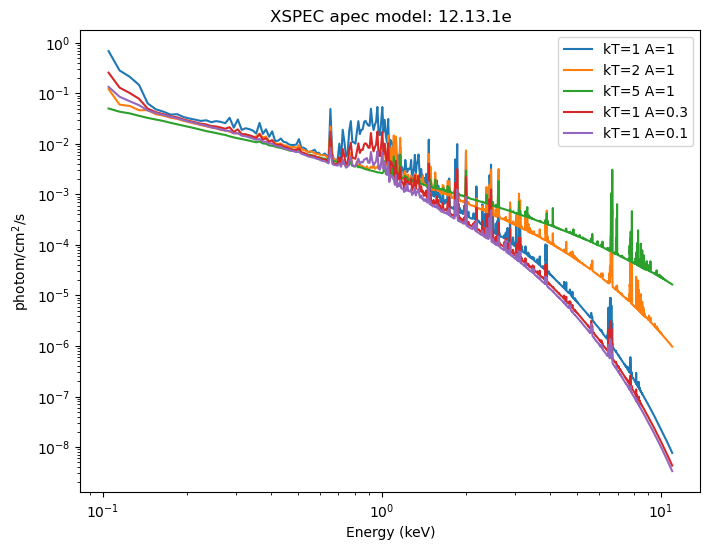

In [22]:
emid = (elo + ehi) / 2

fig = plt.figure(figsize=(8, 6))

plt.plot(emid, y_1_1, label='kT=1 A=1')
plt.plot(emid, y_2_1, label='kT=2 A=1')
plt.plot(emid, y_5_1, label='kT=5 A=1')
plt.plot(emid, y_1_03, label='kT=1 A=0.3')
plt.plot(emid, y_1_01, label='kT=1 A=0.1')

plt.xlabel('Energy (keV)')
plt.ylabel('photom/cm$^2$/s')
plt.legend()

plt.xscale('log')
plt.yscale('log')
plt.title(f'XSPEC apec model: {get_xsversion()}');

Normally this is displayed "per keV", wihch we can get by dividing each bin by `ehi - elo`, but in this case each bin has the same width (0.01 keV), so all this would do would be to change the Y axis values, but not the shape.

#### No instruments!

The above has not used any instrument response (RMF or ARF), since we care here about the spectra before it has interacted with a telescope.

## 2. Manually calculating the flux

Since we can evaluate the model, we can use this to directly calculate the flux from a given model, as I'll discuss in this section. The following sections are all ways that Sherpa provides that automate this process, but I feel it's useful to know how to do it manually.

As mentioned when plotting the models, XSPEC additive models produce results with units of photon/cm$^2$/s. This means that summing up the values over over the desired energy range will give us the flux. As an example, I go back to the XSPEC power-law model (since this has an analytic form we can compare numerical results to):

If we represent the model as $S(E)$ with $$S(E) = A E^{-\gamma}$$ - where $A$ is the normalization and $\gamma$ equal to the `PhoIndex` parameter - then the photon flux for the energy range $E_1$ to $E_2$ is 

$$
\begin{eqnarray}
\rm{pflux}(E_1, E_2) & = & A \int_{E_1}^{E_2} E^{-\gamma} dE \\
 & = & \frac{A}{1 - \gamma} [E^{1 - \gamma}]^{E_2}_{E_1}
\end{eqnarray}
$$

as long as $\gamma \ne 1$.

We can compare this analytic expression to the model-calculated version. First I set up a power-law model with a slope of 1.7 and normaliation of $10^{-4}$ photon/cm$^2$/s/keV:

In [23]:
xpl.phoindex = 1.7
xpl.norm = 1e-4
xpl

<XSpowerlaw model instance 'xspowerlaw.xpl'>

So, the expected photon flux for the range 0.5-7 keV is:

In [24]:
gterm = 1.0 - xpl.phoindex.val
expected = xpl.norm.val * (7**gterm - 0.5**gterm) / gterm
print(f"Expected = {expected:.4e} photon/cm^2/s")

Expected = 1.9548e-04 photon/cm^2/s


For this example I am going to use the 0.5 to 7.0 keV passband. 
I could evaluate the model on `elo` and `ehi` (which are defined over 0.1 to 11 keV) and then filter the answer to the bins we want, but I've decided to just use the energy range I need. As I may just be re-using this a few times in the notebook, I have decided to make it into a small routine:

In [25]:
def calc_pflux(model, elo, ehi, nbins):
    """Calculate the photon flux for the model over the energy range
    
    Parameters
    ----------
    model
        The model instance to evaluate.
    elo, ehi : number
        The energy range, in keV. It is assumed that elo > 0 and ehi > elo.
    nbins : int
        The number of bins to use in the grid. It is assumed that nbins > 0.

    Returns
    -------
    pflux : number
        The model flux for the energy range. It is assumed to be
        in photon/cm^2/s, but this depends on the model instance.
    """
    grid = np.linspace(elo, ehi, nbins)
    y = model(grid[:-1], grid[1:])
    return y.sum()

print("Power-law photon flux (0.5 - 7 keV)")
for n in [10, 100, 1000]:
    pflux = calc_pflux(xpl, 0.5, 7, n)
    print(f" nbins= {n:4d}  -> {pflux:.4e} photon/cm^2/s")

Power-law photon flux (0.5 - 7 keV)
 nbins=   10  -> 1.9548e-04 photon/cm^2/s
 nbins=  100  -> 1.9548e-04 photon/cm^2/s
 nbins= 1000  -> 1.9548e-04 photon/cm^2/s


So, in this particular case the bin size doesn't matter, as even with only 10 bins the photon flux matches the expected value. This is because the power-law model is rather simple. It becomes more important when calculating the energy flux.

The energy flux is given by $\int E S(E) dE$ and so for the powerlaw model the analytic solution is

$$
\begin{eqnarray}
\rm{eflux}(E_1, E_2) & = & A \int_{E_1}^{E_2} E . E^{-\gamma} dE \\
 & = & \frac{A}{2 - \gamma} [E^{2 - \gamma}]^{E_2}_{E_1}
\end{eqnarray}
$$

as long as $\gamma \ne 2$. Note that this gives a result in keV/cm$^2$/s, so we are going to have to convert this to erg/cm$^2$/s using the same constant that Sherpa does.

In [26]:
from sherpa.astro import charge_e

# elementary chare from nist.gov in units appropriate for converting between keV and erg
charge_e

1.60217653e-09

The expected energy-flux for our power-law model is therefore:

In [27]:
gterm = 2.0 - xpl.phoindex.val
expected = charge_e * xpl.norm.val * (7**gterm - 0.5**gterm) / gterm
print(f"Expected = {expected:.4e} erg/cm^2/s")

Expected = 5.2366e-13 erg/cm^2/s


This time the bin size does make a difference when calculating the model flux, since we are approximating the integral by the trapezoidal rule, and weighting each bin with its mid-point: 

In [28]:
def calc_eflux(model, elo, ehi, nbins):
    """Calculate the photon flux for the model over the energy range
    
    Parameters
    ----------
    model
        The model instance to evaluate.
    elo, ehi : number
        The energy range, in keV. It is assumed that elo > 0 and ehi > elo.
    nbins : int
        The number of bins to use in the grid. It is assumed that nbins > 0.

    Returns
    -------
    pflux : number
        The model flux for the energy range. It is assumed to be
        in erg/cm^2/s, but this depends on the model instance.
    """
    grid = np.linspace(elo, ehi, nbins)
    glo, ghi = (grid[:-1], grid[1:])
    y = model(glo, ghi)
    
    # use the mid-point energy, convert from keV to erg
    gmid = charge_e * (glo + ghi) / 2
    return (gmid * y).sum()

print("Power-law energy flux (0.5 - 7 keV)")
for n in [10, 100, 1000]:
    eflux = calc_eflux(xpl, 0.5, 7, n)
    print(f" nbins= {n:4d}  -> {eflux:.4e} erg/cm^2/s")

Power-law energy flux (0.5 - 7 keV)
 nbins=   10  -> 5.4375e-13 erg/cm^2/s
 nbins=  100  -> 5.2385e-13 erg/cm^2/s
 nbins= 1000  -> 5.2367e-13 erg/cm^2/s


## 3. Setting up the data in Sherpa

Whilst you can calculate the flux manually, there are a number of routine provided by Sherpa for doing this for you. As they are
intended for use as part of a "normal" Sherpa session (or script)
they rely on having a PHA dataset loaded.

For this, I'll use a spectrum from
[release 2 of the Chandra Source Catalog](https://cxc.harvard.edu/csc2/), as I happen to have it on disk and it is well described by an absorbed power-law model.

In [29]:
load_pha('acisf11309_000N023_r0002_pha3.fits.gz')
subtract()
ignore(None, 0.5)
ignore(7, None)

read ARF file acisf11309_000N022_r0002_arf3.fits
read RMF file acisf11309_000N022_r0002_rmf3.fits
read background file acisf11309_000N023_r0002_pha3.fits
dataset 1: 0.0073:14.9504 -> 0.511:14.9504 Energy (keV)
dataset 1: 0.511:14.9504 -> 0.511:6.9934 Energy (keV)


For this example I want to use chi-square statistics, so I group the data into bins of at least 15 counts
with the [group_counts](https://cxc.cfa.harvard.edu/sherpa/ahelp/group_counts.html) call (prior to CIAO 4.16 I had to use the `tabStops` argument to only apply the grouping over the
selected energy range, but this is now the default behavior):

In [30]:
group_counts(15)

dataset 1: 0.511:6.9934 Energy (keV) (unchanged)


The data can be displayed in a notebook (for PHA data we get a plot of the data and tables summarizing the observation):

In [31]:
get_data()

<DataPHA data set instance 'acisf11309_000N023_r0002_pha3.fits.gz'>

For this example I shall use Chi-square statistics (errors set to the square-root of the number of counts in a bin):

In [32]:
set_stat('chi2datavar')

and for with an absorbed powerlaw model:

In [33]:
set_source(xsphabs.gal * powlaw1d.pl)

For this example I am going to fix the absorption to use the column density from the
[colden tool](https://cxc.cfa.harvard.edu/ciao/ahelp/colden.html),
which requires converting the approximate position of this source
(00$^h$ 03$^m$ 39$^s$ +16$^\circ$ 02$^{'}$ 20$^{''}$) to decimal and
then running colden, using Python modules provided with the CIAO contributed package:

In [34]:
from coords.format import ra2deg, dec2deg

ra = ra2deg("00 03 39")
dec = dec2deg("+16 02 20")

In [35]:
from ciao_contrib.proptools import colden

nh = colden(ra, dec)
print(f"N_H = {nh} * 1e20 cm^-2")

N_H = 3.69 * 1e20 cm^-2


The absorption models have units of

In [36]:
gal.nh.units

'10^22 atoms / cm^2'

whereas `colden` returns values in units of 10$^{20}$ atoms cm$^{-2}$, so let's scale the result before
[freezing](https://cxc.cfa.harvard.edu/sherpa/ahelp/freeze.html) 
the parameter. 

In [37]:
gal.nh = nh / 100
freeze(gal.nh)

Now I can fit:

In [38]:
fit()

Dataset               = 1
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 5.75307e+11
Final fit statistic   = 115.737 at function evaluation 19
Data points           = 136
Degrees of freedom    = 134
Probability [Q-value] = 0.870659
Reduced statistic     = 0.863709
Change in statistic   = 5.75307e+11
   pl.gamma       1.72494      +/- 0.0372655   
   pl.ampl        0.000110411  +/- 2.99675e-06 


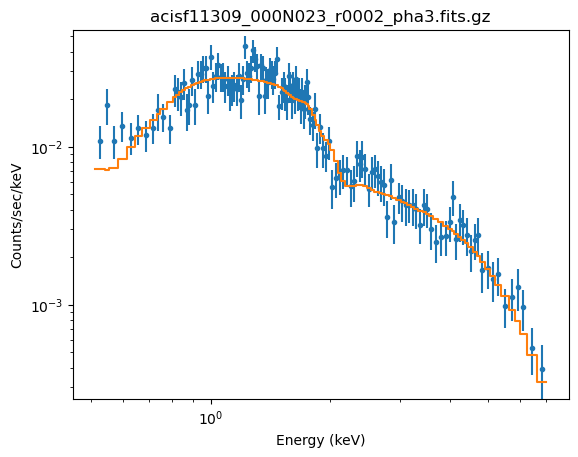

In [39]:
plot_fit(xlog=True, ylog=True)

The reason for fixing the absorption to the Galactic value is that it is large enough to make a difference in the predicted spectrum (the blue line in the plot below, compared to the unabsorbed model shown by the orange line). If the $n_H$ parameter were allowed to vary the best-fit is much closer to 0.

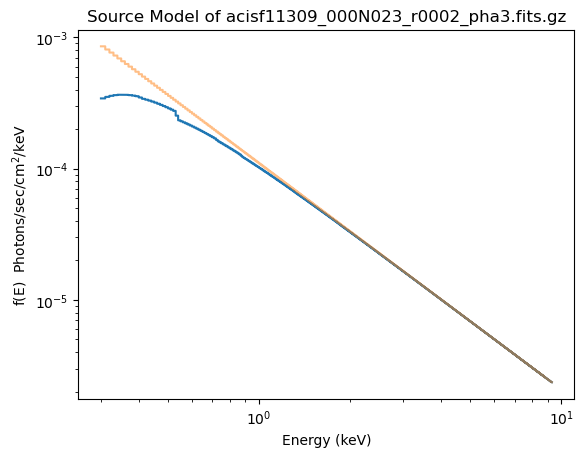

In [40]:
plot_source(xlog=True, ylog=True)
plot_source_component(pl, overplot=True, alpha=0.5)

## 4. calculate_energy_flux

The basic routines for PHA data are 
[calc_photon_flux](https://cxc.cfa.harvard.edu/sherpa/ahelp/calc_photon_flux.html)
and
[calc_energy_flux](https://cxc.cfa.harvard.edu/sherpa/ahelp/calc_energy_flux.html).
You can call them without any arguments, but this is not advised as the energy range is
then set by the instrument response.  I am going to always use them with a given pass band 
(i.e. energy range), so that I know what I'm calculating:

In [41]:
p1 = calc_photon_flux(lo=0.5, hi=7)
e1 = calc_energy_flux(lo=0.5, hi=7)

In [42]:
print(f"p1 = {p1:.4e} photon/cm^2/s")
print(f"e1 = {e1:.4e} erg/cm^2/s")

p1 = 1.9638e-04 photon/cm^2/s
e1 = 5.4455e-13 erg/cm^2/s


These results can be compared to the analytic answer (using the photon flux for demonstration purposes, and noting that the XSPEC and Sherpa power-law models are the same, they just have different parameter names):

In [43]:
gterm = 1.0 - pl.gamma.val
expected = pl.ampl.val * (7**gterm - 0.5**gterm) / gterm
print(f"Expected = {expected:.4e} photon/cm^2/s")

Expected = 2.1457e-04 photon/cm^2/s


### 4.1 Absorbed versus unabsorbed fluxes

The fact that the analytic solution is larger than the calculated value is because both `calc_photon_flux` and `calc_energy_flux` use the full model expression - that is an absorbed power-law - which is going to result in a smaller flux than the power-law only (i.e. unabsorbed) component.

The CIAO 4.12.1 release added the model argument to `calc_energy_flux` which makes it easy to calculate unabsorbed fluxes too. Setting the model argument to `pl` in this example will calculate the unabsorbed flux.

In [44]:
p2 = calc_photon_flux(lo=0.5, hi=7, model=pl)
e2 = calc_energy_flux(lo=0.5, hi=7, model=pl)

The photon-flux is now the same as the expected value (at least to the fourth decimal place in this particular example):

In [45]:
print(f"p2 = {p2:.4e} photon/cm^2/s")
print(f"  vs {expected:.4e}\n")
print(f"e2 = {e2:.4e} erg/cm^2/s")

p2 = 2.1457e-04 photon/cm^2/s
  vs 2.1457e-04

e2 = 5.6688e-13 erg/cm^2/s


It is important to only calculate a flux for an XSPEC additive model component (or a combination of multiplicative * additive). The `calc_energy_flux` routine will allow you to specify a XSPEC multiplicative model - here this would be `model=gal` - but the number is meaningless.

## 5. How about parameter errors?

A simple solution for estimating the error on the flux is to just use the fractional error on the normalization (or amplitude) parameter, and apply that to the flux. However, this ignores the influence on any other model parameters on the flux calculation (so in our example the slope of the power law).

Sherpa provides three routines that will simulate the flux distribution based on the parameter errors:

 - [`sample_photon_flux`](https://cxc.cfa.harvard.edu/sherpa/ahelp/sample_photon_flux.html)
 - [`sample_energy_flux`](https://cxc.cfa.harvard.edu/sherpa/ahelp/sample_energy_flux.html)
 - [`sample_flux`](https://cxc.cfa.harvard.edu/sherpa/ahelp/sample_flux.html)
 
If you require photon fluxes then use `sample_photon_flux`, otherwise you can use either of `sample_energy_flux` or `sample_flux`.
The `sample_energy_flux` routins has more features, but `sample_flux` may be a bit easier to use.

All three routines use the same technique: create a random set of the free parameters in the model using a Gaussian distribution centered on the best-fit parameter values and the widths from the errors on these parameters, and then use that set of parameters to calculate the flux. This step is repeated a given number of times, and the resulting flux distribution can be used to estimate the flux errors. Note that the Gaussian distribution can include correlations between the parameters, as we show below.

### 5.1 sample_photon_flux and sample_energy_flux

I am going to first look at `sample_energy_flux`. This will create `num` samples of the free parameters of the model (where `num` is an input argument and defaults to 1) assuming a normal distribution about the current parameter values. The default is to assume un-correlated errors, and to calculate these errors with the
[`covar` routine](https://cxc.cfa.harvard.edu/sherpa/ahelp/covariance). We show how to change these assumptions in sections 5.2 and 5.4. Each sample is then used to calculate a flux, using `calc_energy_flux`, resulting in a distribution of fluxes.

Although not shown here, `sample_photon_flux` works the same way as `sample_energy_flux`, but returns fluxes in units of photon/cm$^2$/s rather than erg/cm$^2$/s.

We can get a visual handle of `sample_energy_flux` by using the `plot_energy_flux` function to plot up 1000 samples of the 0.5 to 7 keV photon flux (the number of bins used for the histogram has been reduced from 75 to 30 as it works better for this dataset, and 1000 iterations have been used as it doesn't take too long for this notebook rather than providing any particular level of accuracy). We can take advantage of the `model` parameter to calculate the fluxes for an unabsorbed component. As expected, the unabsorbed fluxes are on average larger than the absorbed fluxes!

Note that the process involves using random numbers, and so - to ensure the results do not change between runs - I set the random generator to a known value using the (new to CIAO 4.16) [set_rng](https://cxc.cfa.harvard.edu/sherpa/ahelp/set_rng.html) routine coupled with the
[NumPy random generator](https://numpy.org/doc/stable/reference/random/index.html) call:

In [46]:
set_rng(np.random.default_rng(92743))

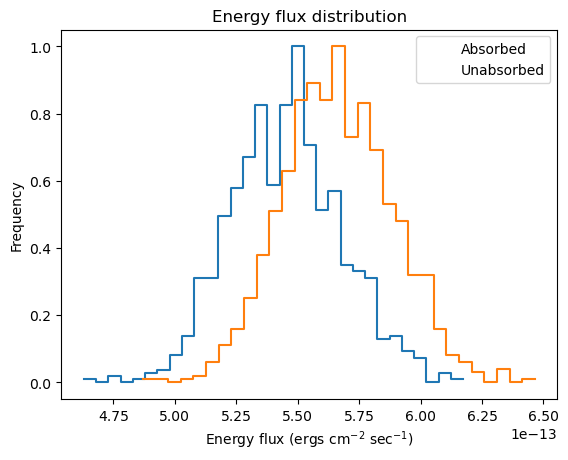

In [47]:
plot_energy_flux(lo=0.5, hi=7, num=1000, bins=30)
plot_energy_flux(lo=0.5, hi=7, num=1000, bins=30, model=pl, overplot=True)

plt.legend(['Absorbed', 'Unabsorbed']);

The `sample_energy_flux` routine - which `plot_energy_flux` uses - returns the actual flux values per iteration (along with the parameter values), as a two-dimensional array (iteration number, and a combination of parameter values, clipping flag, and flux):

In [48]:
sample1 = sample_energy_flux(lo=0.5, hi=7, num=1000)
sample2 = sample_energy_flux(lo=0.5, hi=7, num=1000, model=pl)
print(sample1.shape)
print(sample2.shape)

(1000, 4)
(1000, 4)


We can see that the fluxes - which are the first column - show the same behavior as seen in the `plot_energy_flux` plot
(note that the results will not exactly match because the binning is different *and* the results shown here are a
different realisation than in the `plot_energy_flux` call):

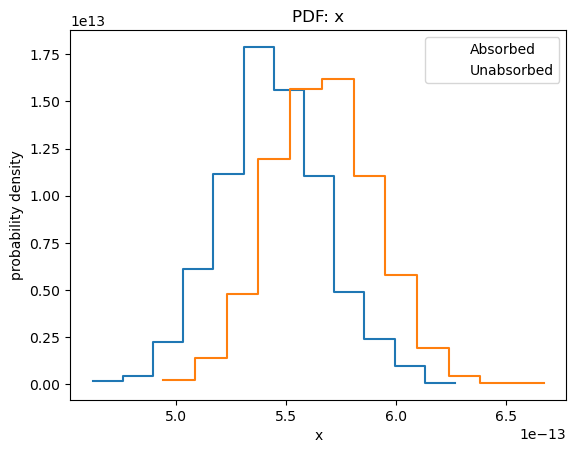

In [49]:
plot_pdf(sample1[:, 0])
plot_pdf(sample2[:, 0], overplot=True)

plt.legend(['Absorbed', 'Unabsorbed']);

In the rest of this section I shall concentrate on the **unabsorbed**, rather than absorbed, fluxes.

Here I plot the ampl and $\gamma$ parameter values used (there's no assumed correlation between these two parameters since the `correlated` argument to `sample_energy_flux` was left at its default setting of `False`), along with a histogram of the flux distribution:

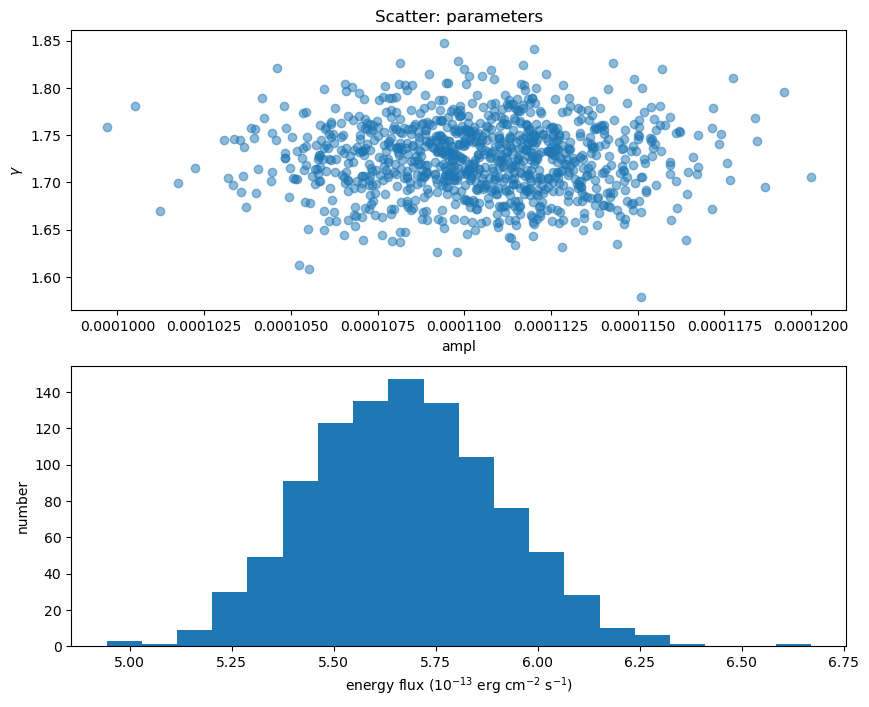

In [50]:
eflux2 = sample2[:, 0] * 1e13
gamma2 = sample2[:, 1]
ampl2 = sample2[:, 2]
clip2 = sample2[:, 3]

fig = plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plot_scatter(ampl2, gamma2, alpha=0.5, markersize=12, clearwindow=False,
            xlabel="ampl", ylabel=r"$\gamma$", name="parameters")

plt.subplot(2, 1, 2)
plt.hist(eflux2, bins=20)
plt.xlabel(r"energy flux ($10^{-13}$ erg cm$^{-2}$ s$^{-1}$)")
plt.ylabel("number");

We can compare the power-law normalization (i.e. the `ampl` parameter) to the calculated flux, to show that they are correlated, but that there is scatter (thanks to $\gamma$ varying).

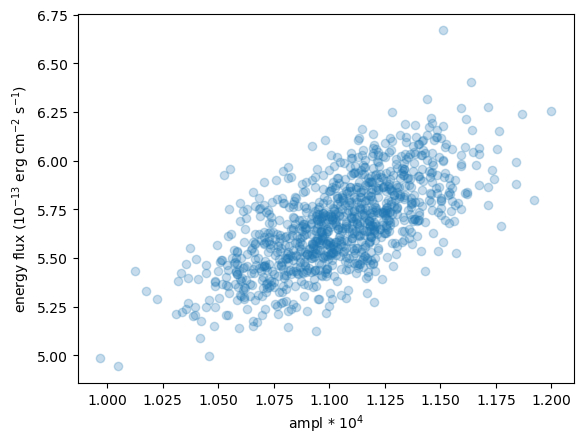

In [51]:
# We can use Matplotlib commands as well as the pre-canned routines like
# plot_scatter.
plt.scatter(ampl2 * 1e4, eflux2, alpha=0.25)
plt.xlabel("ampl * 10$^4$")
plt.ylabel("energy flux ($10^{-13}$ erg cm$^{-2}$ s$^{-1}$)");

The last column (here referred to as `clip2`) is a flag column, and indicates whether any of the parameter samples fell outside of the limits set by the `clip` parameter and were replaced bu the limit. The default setting for `clip` is `'hard'`, which means that only those rows where a parameter falls outside its hard limits will be flagged. For this model and dataset it is unlikely to happen, which we can check by looking if any value in `clip2` is not 0 (this column only has values of 0 and 1 but is stored as a floating-point value):

In [52]:
(clip2 > 0).sum()

0

This is the time for the `corner` module to shine, since it is designed to visualize the correlations for data like the return value from `sample_energy_flux`. There are a number of customization options for the plot, but let's see what the defaults look like, other than adding in the column labels (thanks to the way that the notebook works, I add a semi-colon so that the return value isn't displayed automatically, as this then leads to the plot being duplicated).

Since the last column is all zeros I remove it from the call with `sample2[:, :-1]`:

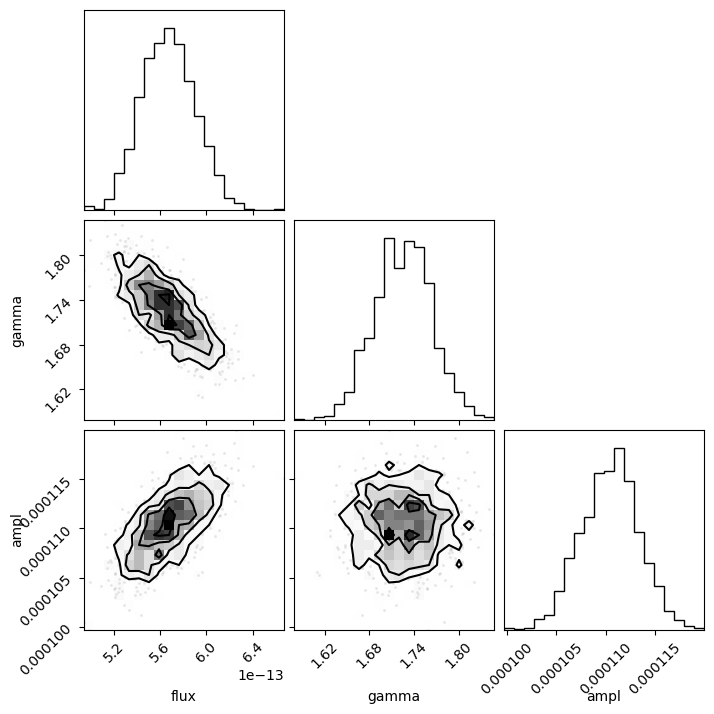

In [53]:
corner.corner(sample2[:, :-1], labels=["flux", "gamma", "ampl"]);

The diagonal elements show the histograms of the columns, and the other terms plot the distribution of the two column values. The binning used in these histograms is designed to show the structure of the data (and is more advanced than the simple scatter plots I showed above).

We can even overlay the distributions we got for the unabsorbed (`orange`) on top of the absorbed (`black`)
results. We can clearly see the shift in the flux distribution, but the parameter values remain similar:

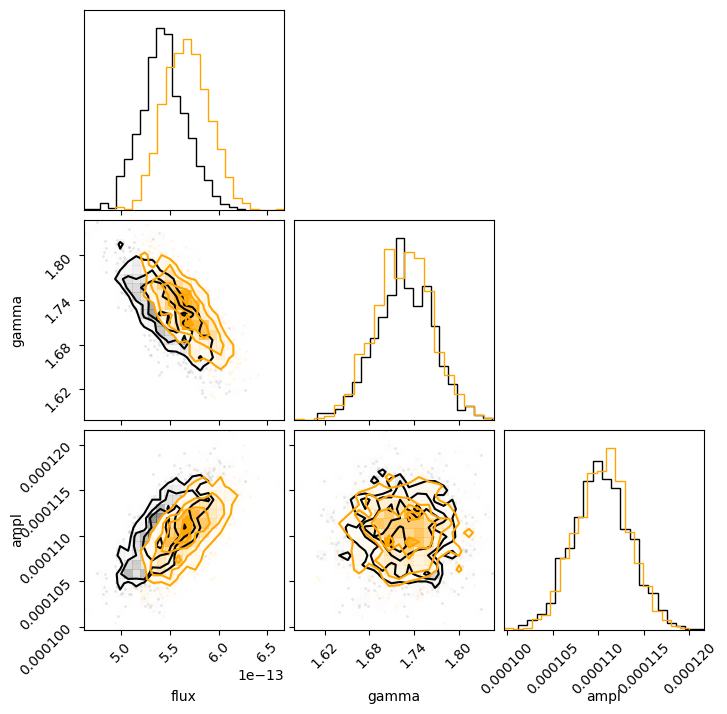

In [54]:
c = corner.corner(sample1[:, :-1], labels=["flux", "gamma", "ampl"]);
corner.corner(sample2[:, :-1], fig=c, color="orange");

We can use NumPy routines to extract the calculated energy flux values; in this case I chose to look at the median value along with the one-sigma range from the distribution.

In [55]:
efluxes2 = eflux2.copy()
efluxes2.sort()

med2, lsig2, usig2 = np.percentile(efluxes2, [50, 15.87, 84.13])

print(f"Median = {med2:.4f}      * 1e-13 erg/cm^2/s")
print(f"    {lsig2:.4f} - {usig2:.4f}  * 1e-13 erg/cm^2/s")

Median = 5.6717      * 1e-13 erg/cm^2/s
    5.4404 - 5.9099  * 1e-13 erg/cm^2/s


We can use Sherpa's
[plot_cdf](https://cxc.cfa.harvard.edu/sherpa/ahelp/plot_cdf.html) function for displaying the cumulative distribution function:

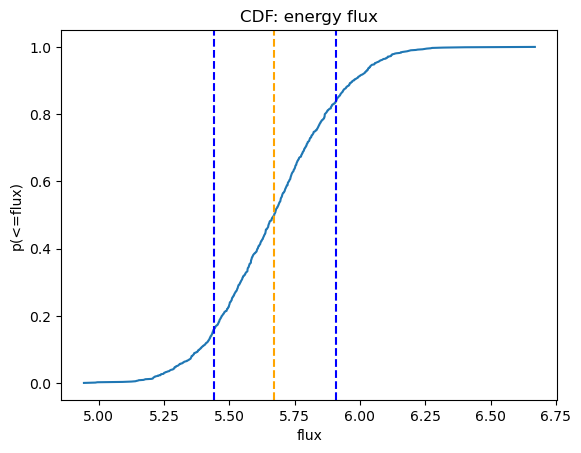

In [56]:
plot_cdf(efluxes2, xlabel="flux", name="energy flux")

### 5.2 correlated=True

As shown earlier, there was no assumed correlation between the amplitude and slope parameters when simulating the fluxes. However, we  normally find there is some correlation: for this fit we can use the
[reg_proj function](https://cxc.cfa.harvard.edu/sherpa/ahelp/reg_proj.html)
to show that as the slope - i.e. $\gamma$ - increases, so does the amplitude.

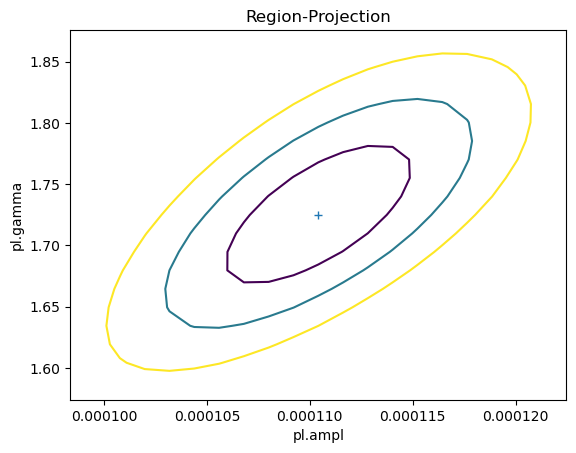

In [57]:
reg_proj(pl.ampl, pl.gamma, nloop=[21, 21])

If we set the `correlated` parameter to `True` when calling `sample_energy_flux` then the covariance matrix will be used to define parameter correlations.

In [58]:
sample3 = sample_energy_flux(lo=0.5, hi=7, num=1000, correlated=True, model=pl)
eflux3 = sample3[:, 0] * 1e13
gamma3 = sample3[:, 1]
ampl3 = sample3[:, 2]

First let's check whether we really do see a difference in the parameter values (i.e. were the correlations used in the samples?). I have overdrawn the contours from `reg_proj` to show that the correlated version matches, in shape at least.

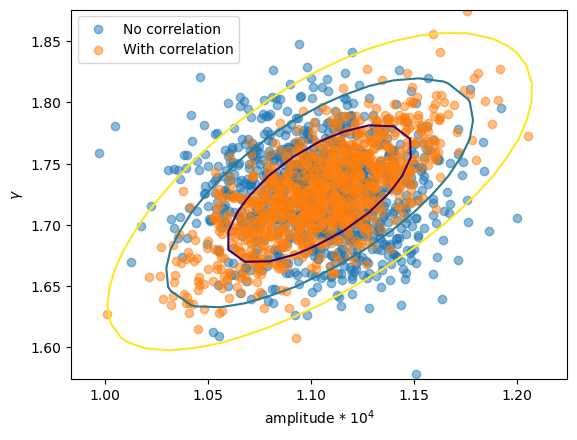

In [59]:
plt.scatter(ampl2 * 1e4, gamma2, alpha=0.5, label="No correlation")
plt.scatter(ampl3 * 1e4, gamma3, alpha=0.5, label="With correlation")

# overplot the reg_proj contours
rproj = get_reg_proj()
x0 = rproj.x0.reshape(*rproj.nloop).copy()
x1 = rproj.x1.reshape(*rproj.nloop).copy()
y = rproj.y.reshape(*rproj.nloop).copy()
plt.contour(x0 * 1e4, x1, y, levels=rproj.levels)

plt.xlabel("amplitude * 10$^4$")
plt.ylabel(r"$\gamma$")
plt.legend();

So, the first run used uncorrelated samples, which results in an ellipse parallel to the horizontal, whereas the correlated version has the major axis rotated.

Does this make a difference to the flux distribution?

In [60]:
efluxes3 = eflux3.copy()
efluxes3.sort()

med3, lsig3, usig3 = np.percentile(efluxes3, [50, 15.87, 84.13])

print(f"Median = {med3:.4f}      * 1e-13 erg/cm^2/s")
print(f"    {lsig3:.4f} - {usig3:.4f}  * 1e-13 erg/cm^2/s")

Median = 5.6674      * 1e-13 erg/cm^2/s
    5.5446 - 5.8063  * 1e-13 erg/cm^2/s


We can see below, where I overlay the cumulative distributions, that the medians are essentially the same$^\dagger$, but that the distribution of fluxes when the parameters are correlated is narrower (and so has a smaller error range).

---
$^\dagger$ although the exact difference depends on the random generator used.

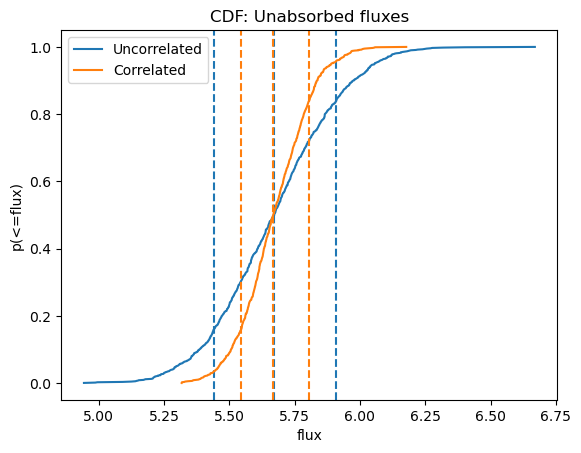

In [61]:
plot_cdf(efluxes2, xlabel="flux", name="Unabsorbed fluxes")
plot_cdf(efluxes3, overplot=True)

# Add a legend (please don't peak behind the curtains)
ax = plt.gca()
for i in [1, 2, 3]:
    ax.lines[i].set_color(ax.lines[0].get_color())
for i in [5, 6, 7]:
    ax.lines[i].set_color(ax.lines[4].get_color())

plt.legend((ax.lines[0], ax.lines[4]), ("Uncorrelated", "Correlated"));

This can also be seen by using the `corner` module to overplot the two distributions (the correlated version is in orange):

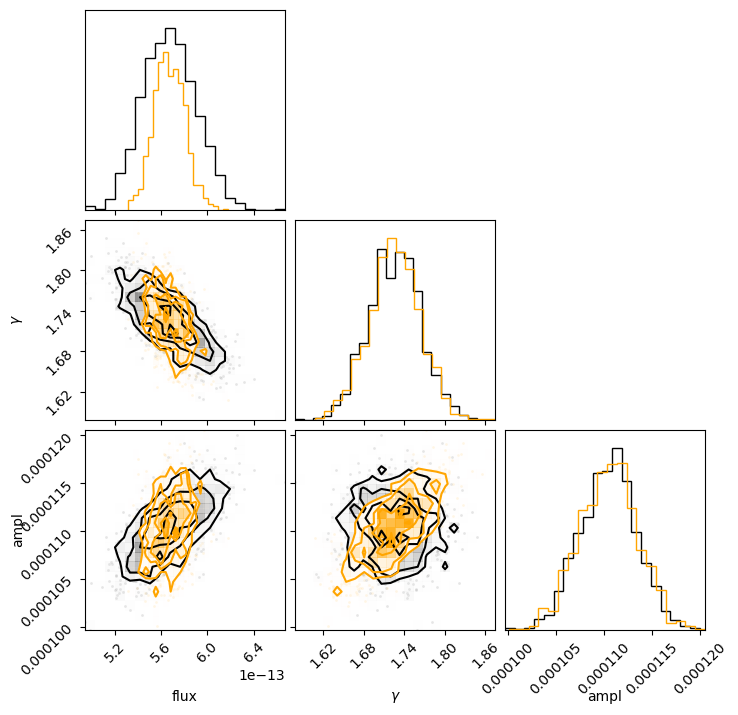

In [62]:
c = corner.corner(sample2[:, :-1], labels=["flux", r"$\gamma$", "ampl"])
corner.corner(sample3[:, :-1], fig=c, color="orange");

We can see that the flux distribution is narrower in the correlated version but centered about the
same location, and the actual model parameters have similar one-dimensional distributions.

### 5.3 A note on clipping

If a sampled parameter exceeds the clip limit (by default the `hard` limit, but it can also be the soft limits) then that parameter will be
replaced by the value at the limit, and the clip flag for the row (the last column) will be set to 1. This can be useful when a source is
faint and so is not well detected, or a parameter is not well constrained (e.g. the n$_H$ parameter of an absorption model), and you want
to post-process the fluxes to include or exclude parameters at the limit.

Note that the hard limits of a parameter are provided by the `hard_min` and `hard_max` attributes, as shown below for the power-law $\gamma$ and $n_H$ column density:

In [63]:
pl.gamma.hard_min, pl.gamma.hard_max

(-3.4028234663852886e+38, 3.4028234663852886e+38)

In [64]:
gal.nh.hard_min, gal.nh.hard_max

(0.0, 1000000.0)

and the soft limits by the `min` and `max` attributes:

In [65]:
pl.gamma.min, pl.gamma.max

(-10.0, 10.0)

In [66]:
gal.nh.min, gal.nh.max

(0.0, 1000000.0)

Section 5.7 contains an example when the clipping parameter makes a difference.

### 5.4 What errors are used?

The `sample_energy_flux` and `sample_photon_flux` routines require an error estimate to generate the parameter samples. The default is to run the 
[covar routine](https://cxc.cfa.harvard.edu/sherpa/ahelp/covariance.html) to calculate the covariance matrix, and use that (just the diagonal elements when `correlated` is `False`).

The `scales` parameter can be used to send in either a one- or two-dimensional matrix (size and ordering match the free parameters of the model) to define the errors used in the simulation. A normal (i.e. symmetric) distribution is used in the sampling.

### 5.5 sample_flux

The [`sample_flux`](https://cxc.cfa.harvard.edu/sherpa/ahelp/sample_flux.html) is similar to `sample_energy_flux` but
has several differences in what values are returned. It also automatically clips the flux results to exclude any
rows that are are equal to (or outside) the **soft** limits of the parameters, which can be problematic when
calculating fluxes for un-detected sources (where parameter values may hit the soft limits0.

**NOTE**: Several restrictions and limitations in `sample_flux` have been lifted - in particular it can now be used with datasets other than the default identifier and the clipping has been changed. See "help(sample_flux)" for more details.

**NOTE**: In CIAO 4.15, the `sample_flux` routine is restricted to calculating the energy flux for PHA data sets (setting `Xrays=False` will result in an error).

Unlike `sample_energy_flux`, `sample_flux` returns three items:

 - the errors for the "full" model (median and one-sigma limits);
 - the errors for the "component" model (median and one-sigma limits);
 - and the parameter values used for the simulations along with the fluxes for the "full" model.

It will also display the calculated errors on the screen. In the following I have not set the `modelcomponent`
parameter - which is the same as the `model` argument for `calc_energy_flux` and `sample_energy_flux` - and
so the first two arguments will be the same.

In [67]:
res1 = sample_flux(lo=0.5, hi=7, num=1000)

original model flux = 5.42717e-13, + 2.21421e-14, - 2.11682e-14
model component flux = 5.42717e-13, + 2.21421e-14, - 2.11682e-14


In [68]:
fflux1 = res1[0]
vals1 = res1[2]

Section 5.6 discusses using the `modelcomponent` to calculate the fluxes for a single component.

The flux argument gives the median and one-sigma upper and lower limits (since I did not change the `confidence` parameter from its default value of `68`):

In [69]:
fflux1

array([5.42717494e-13, 5.64859607e-13, 5.21549272e-13])

The third element is similar to the return value of `sample_energy_flux` - that is the flux, clip flag, and parameter values for each iteration - except that it has an extra value, the statistic value for the sample:

In [70]:
vals1.shape

(1001, 5)

In [71]:
ef1 = vals1[:, 0] * 1e13  # flux
g1 = vals1[:, 1]          # parameter: gamma
n1 = vals1[:, 2]          # parameter: ampl
c1 = vals1[:, 3]          # was the row clipped to match the soft limits
s1 = vals1[:, 4]          # statistic

We can use this extra information, for instance by coloring the points with the statistic value (top plot):

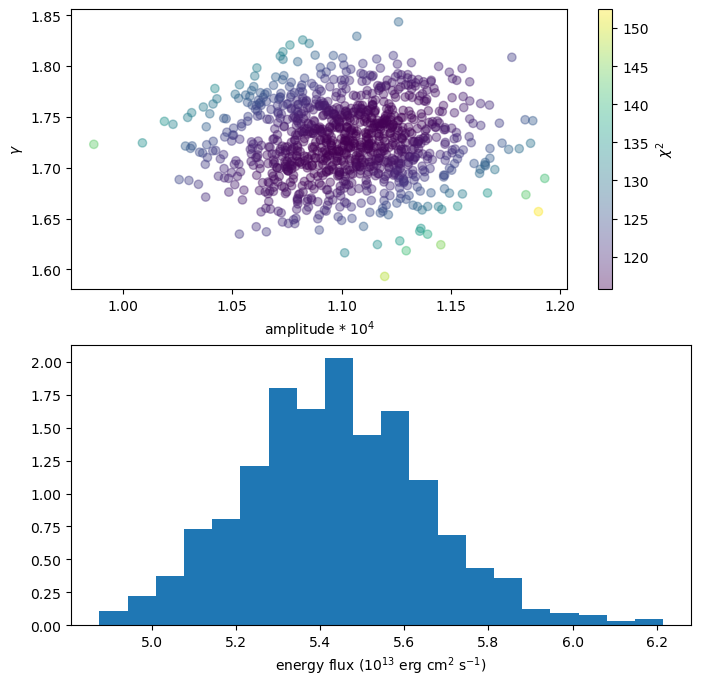

In [72]:
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.scatter(n1 * 1e4, g1, alpha=0.4, c=s1)
cbar = plt.colorbar()
plt.xlabel("amplitude * 10$^{4}$")
plt.ylabel(r"$\gamma$")
cbar.set_label(r"$\chi^2$")
           
plt.subplot(2, 1, 2)
plt.hist(ef1, density=True, bins=20)
plt.xlabel("energy flux (10$^{13}$ erg cm$^2$ s$^{-1}$)");

As with `sample_energy_flux` we can change the `correlated` flag or explicitly set the errors, with the `scales`
parameter. Remember that the third samples argument returned by `sample_flux` contains - in its first column - the
flux using the "full" model, even when the `modelcomponent` is given.

In [73]:
res2 = sample_flux(lo=0.5, hi=7, num=1000, correlated=True)

original model flux = 5.44137e-13, + 1.19119e-14, - 1.24999e-14
model component flux = 5.44137e-13, + 1.19119e-14, - 1.24999e-14


In [74]:
print(res1[0])
print(res2[0])

[5.42717494e-13 5.64859607e-13 5.21549272e-13]
[5.44136694e-13 5.56048620e-13 5.31636761e-13]


We again see that the flux distribution calculated using correlated errors is tighter than the un-correlated version (this time I use a histogram/PDF rather than cumulative plot):

In [75]:
fflux2 = res2[0]
vals2 = res2[2]

ef2 = vals2[:, 0] * 1e13 # flux

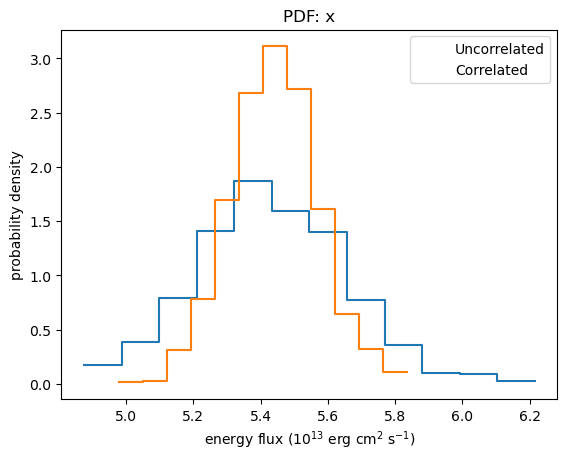

In [76]:
plot_pdf(ef1)
plot_pdf(ef2, overplot=True)

plt.legend(["Uncorrelated", "Correlated"])
plt.xlabel("energy flux (10$^{13}$ erg cm$^2$ s$^{-1}$)");

As with `sample_energy_flux`, the `corner` module can also be used to display and compare the distributions, although it is a
bit-more messy to remove the clipped column as it is no-longer the last column:

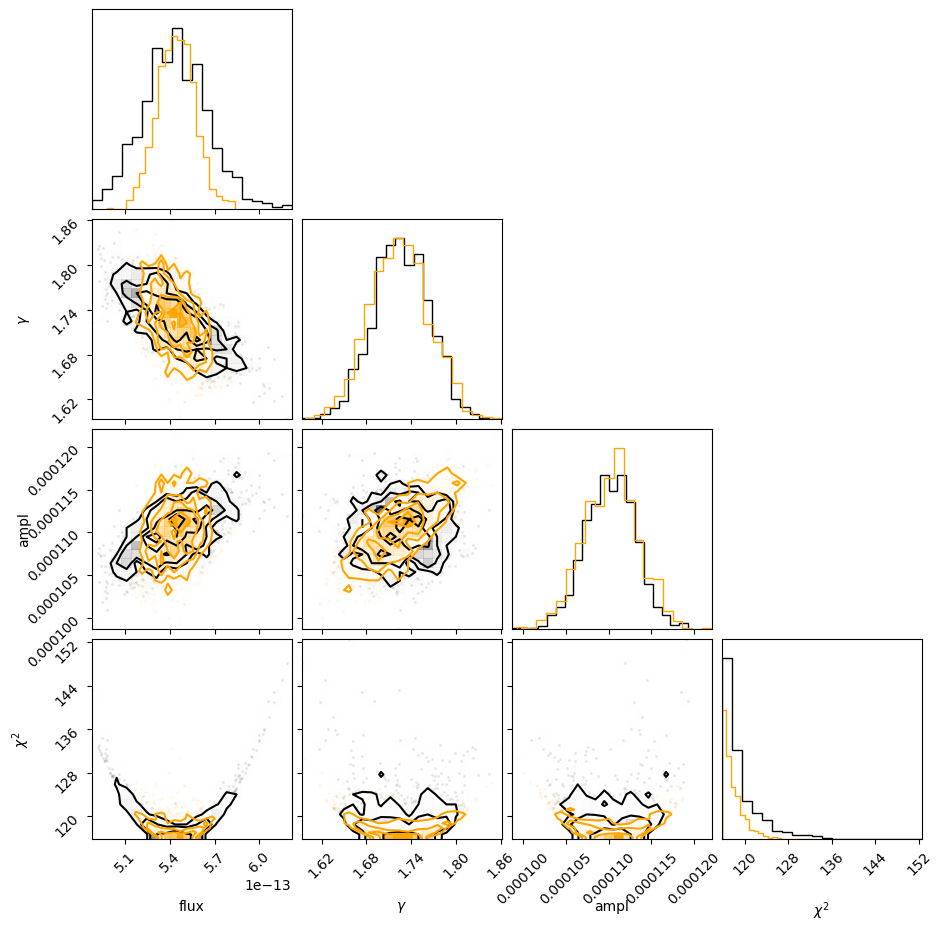

In [77]:
idx = [0, 1, 2, 4]
v1 = vals1[:, idx]
v2 = vals2[:, idx]

c = corner.corner(v1, labels=["flux", r"$\gamma$", "ampl", r"$\chi^2$"]);
corner.corner(v2, fig=c, color='orange');

### 5.6 sample_flux and unabsorbed fluxes

Setting the `modelcomponent` argument tells `sample_flux` to calculate two sets of fluxes: the full source expression (`original`) value, reported first, and the component-only flux (`component`) second.

Here we can see that the unabsorbed flux (i.e. just `pl` and not `gal * pl`) is higher than the absorbed flux, as it should be.

In [78]:
ures = sample_flux(modelcomponent=pl, lo=0.5, hi=7, num=1000, correlated=True)

original model flux = 5.45136e-13, + 1.25053e-14, - 1.21007e-14
model component flux = 5.67324e-13, + 1.28636e-14, - 1.23612e-14


Just to re-iterate, the median and one-sigma limits of the absorbed flux (first element) compared to the unabsorbed flux (second element):

In [79]:
print(ures[0])
print(ures[1])

[5.45136420e-13 5.57641749e-13 5.33035697e-13]
[5.67324388e-13 5.80188017e-13 5.54963192e-13]


That is

In [80]:
print("\n# sample_flux (unabsorbed)")
xs = ures[1] * 1e13
print(f"Median = {xs[0]:.4f}      * 1e-13 erg/cm^2/s")
print(f"    {xs[2]:.4f} - {xs[1]:.4f}  * 1e-13 erg/cm^2/s")


# sample_flux (unabsorbed)
Median = 5.6732      * 1e-13 erg/cm^2/s
    5.5496 - 5.8019  * 1e-13 erg/cm^2/s


Note that in CIAO 4.16 the flux distribution returned in this case is still for the full model expression, and **not** the `modelcomponent`. We can
show this by comparing the median of the flux column to the first elements of `ures[0]` and `ures[1]` and seeing which one matches:

In [81]:
np.median(ures[2][:, 0])

5.451364203459197e-13

### 5.7 sample_energy_flux versus sample_flux

Here I compare the flux distribution for the fluxes from `sample_energy_flux` and `sample_flux`,
using the `correlated=True` case and for the unabsorbed power-law component (re-running
everything since I have decided to chose a softer energy band for this calculation).

Note that the `clip` parameter for `sample_energy_flux` is set to `soft`
to more-closely match the behavior of `sample_flux` (this behavior changed in CIAO 4.14).

In order to discuss the clipping behavior, I have thawed the n$_H$ parameter since the error
range is large enough to cover the minimum value for the parameter (which in this case is n$_H$ = 0).

In [82]:
gal.nh.thaw()

In [83]:
fit()

Dataset               = 1
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 115.737
Final fit statistic   = 114.385 at function evaluation 21
Data points           = 136
Degrees of freedom    = 133
Probability [Q-value] = 0.876576
Reduced statistic     = 0.860038
Change in statistic   = 1.35192
   gal.nH         0.000784835  +/- 0.0286716   
   pl.gamma       1.65682      +/- 0.0662205   
   pl.ampl        0.000102313  +/- 6.89123e-06 


In [84]:
get_fit_results()

<Fit results instance>

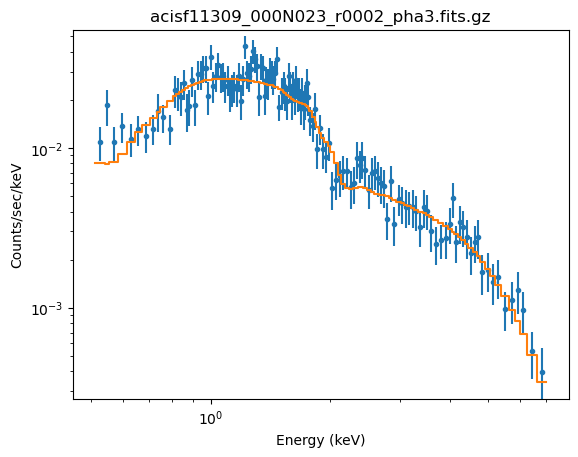

In [85]:
plot_fit(xlog=True, ylog=True)

The `sample_energy_flux` and `sample_flux` calls are as before, but now show off a warning
about hitting the minimum value for the `gal.nH` parameter:

In [86]:
seflux = sample_energy_flux(lo=0.5, hi=2, model=pl, clip="soft", correlated=True, num=1000)

In [87]:
sflux = sample_flux(lo=0.5, hi=2, modelcomponent=pl, correlated=True, num=1000)

original model flux = 2.23692e-13, + 6.45322e-15, - 7.54251e-15
model component flux = 2.38746e-13, + 1.00774e-14, - 8.71833e-15


We can see how the boundary has affected the analysis by comparing the n$_H$ and $\gamma$ parameter
values: the cut off at n$_H$=0 is clear, and the two distributions appear similar.

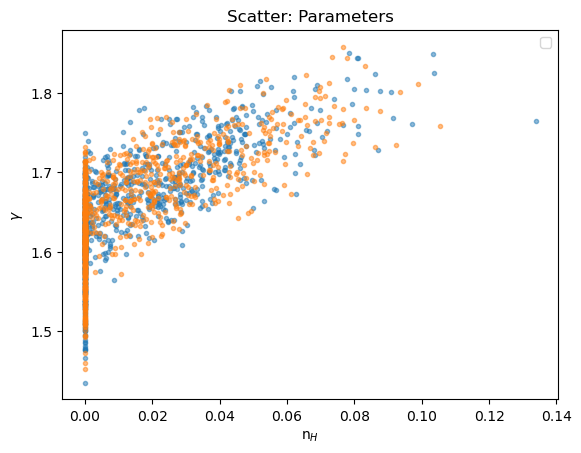

In [88]:
plot_scatter(seflux[:, 1], seflux[:, 2], alpha=0.5, xlabel="n$_H$", ylabel=r"$\gamma$", name="Parameters")
plot_scatter(sflux[2][:, 1], sflux[2][:, 2], alpha=0.5, overplot=True)

plt.legend(["sample_energy_flux", "sample_flux"]);

We can view the `sample_energy_flux` parameters that were clipped (that is, in this case the n$_H$ parameter was reset to 0
from a negative value) by plotting the trace of all the fluxes (as a line) and then overplotting those iterations where the
parameters were clipped as circles:

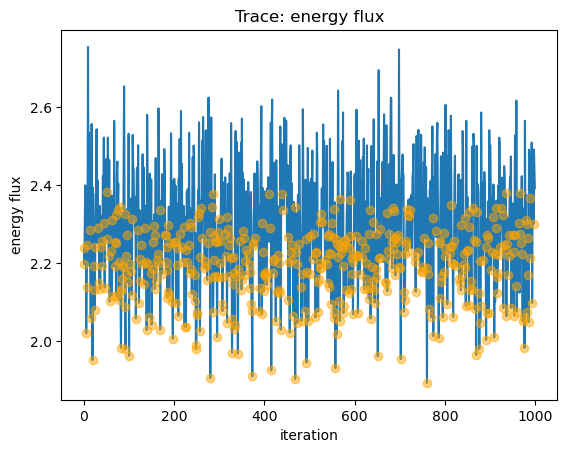

In [89]:
y = seflux[:, 0] * 1e13
plot_trace(y, name="energy flux")

niter = np.arange(seflux[: , 0].size)
clipped = seflux[:, -1] > 0
plt.plot(niter[clipped], y[clipped], "o", c="orange", alpha=0.5, zorder=2);

We can see what difference these boundary points can make by comparing the full distribution to
only those points that were not clipped:

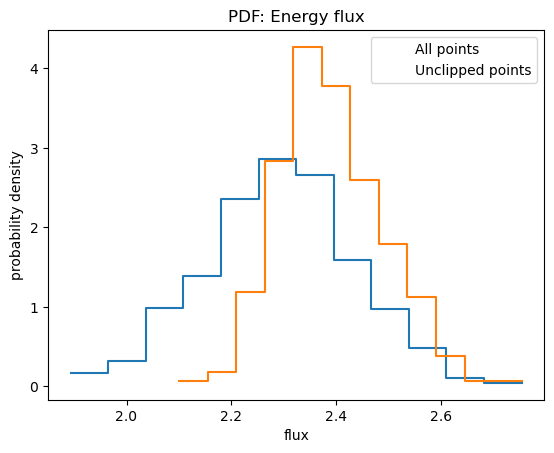

In [90]:
plot_pdf(y, name="Energy flux", xlabel="flux")
plot_pdf(y[~clipped], overplot=True)

plt.legend(["All points", "Unclipped points"]);

In this case removing the clipped points leads to larger fluxes, which can bias
the calculation of upper-limits.

Prior to CIAO 4.14 the `sample_flux` command removed points at the soft limit, which meant that it could bias the results. It now matches `sample_energy_flux` as we can see below, where the limits returned by `sample_flux` are close to the "only within the soft limits" version of the `sample_energy_flux` command.

In [91]:
print("# sample_energy_flux (all)")
med_sef_all, low_sef_all, hi_sef_all = np.percentile(y, [50, 15.87, 84.13])
print("Median = {:.4f}      * 1e-13 erg/cm^2/s".format(med_sef_all))
print("    {:.4f} - {:.4f}  * 1e-13 erg/cm^2/s".format(low_sef_all, hi_sef_all))

print("\n# sample_energy_flux (only within the soft limits)")
med_sef_clipped, low_sef_clipped, hi_sef_clipped = np.percentile(y[~clipped], [50, 15.87, 84.13])
print("Median = {:.4f}      * 1e-13 erg/cm^2/s".format(med_sef_clipped))
print("    {:.4f} - {:.4f}  * 1e-13 erg/cm^2/s".format(low_sef_clipped, hi_sef_clipped))

print("\n# sample_flux")
med_sf, hi_sf, lo_sf = sflux[1] * 1e13
print("Median = {:.4f}      * 1e-13 erg/cm^2/s".format(med_sf))
print("    {:.4f} - {:.4f}  * 1e-13 erg/cm^2/s".format(lo_sf, hi_sf))

# sample_energy_flux (all)
Median = 2.2957      * 1e-13 erg/cm^2/s
    2.1532 - 2.4312  * 1e-13 erg/cm^2/s

# sample_energy_flux (only within the soft limits)
Median = 2.3801      * 1e-13 erg/cm^2/s
    2.2981 - 2.5020  * 1e-13 erg/cm^2/s

# sample_flux
Median = 2.3875      * 1e-13 erg/cm^2/s
    2.3003 - 2.4882  * 1e-13 erg/cm^2/s


We have to compare the un-clipped data from `sample_energy_flux` to the `sample_flux` results to get a match. 

We can identify the number of rows that are affected from `sample_energy_flux` and `sample_flux` directly (as shown above):

In [92]:
(seflux[:, -1] > 0).sum()

476

In [93]:
(sflux[2][:, -2] > 0).sum()

531

We can use this to look at the statistic values and see where the clipped values lie:

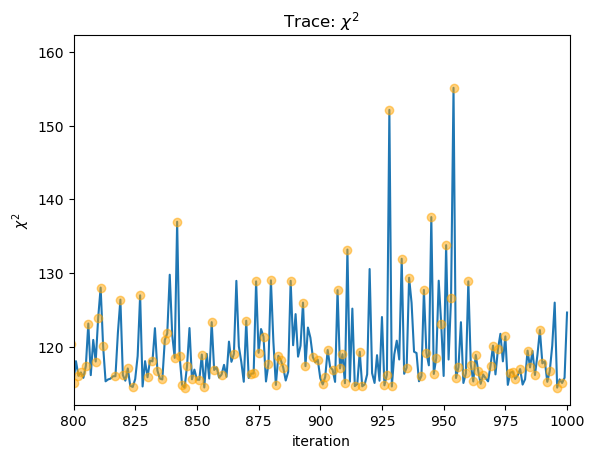

In [94]:
stat = sflux[2][:, -1]
clipped = sflux[2][:, -2] > 0

plot_trace(stat, name=r"$\chi^2$")

niter = np.arange(stat.size)
plt.plot(niter[clipped], stat[clipped], "o", c="orange", alpha=0.5, zorder=2);
plt.xlim(800, 1001);

## 6. XSPEC's cflux model

XSPEC provides several "convolution" models for calculating flux and luminosites.

You **do not need** to use `xscflux`, as the previous approaches (hopefully) suffice, but I mention it if you want to compare your results to a colleague's XSPEC analysis.

To show how to use the `cflux` component I need a copy of the source dataset. Using
[get_data](https://cxc.cfa.harvard.edu/sherpa/ahelp/get_data.html)
and
[set_data](https://cxc.cfa.harvard.edu/sherpa/ahelp/set_data.html)
makes this fast (although I have to be careful **not** to change settings, such as the noticed energy range, as it will also change the values for dataset 1).

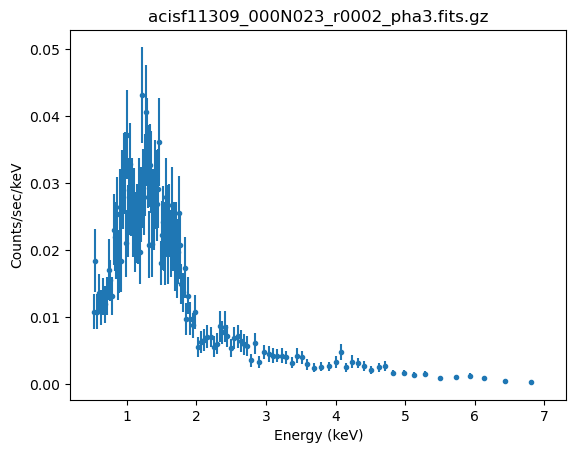

In [95]:
d = get_data()
set_data(2, d)

# Just to check we have a filtered and grouped spectra
plot_data(2)

I first want to set the n$_H$ value back to a fixed value, to make it easy to compare to earlier results (and re-fit):

In [96]:
from sherpa.utils.logging import SherpaVerbosity

gal.nh = nh / 100
freeze(gal.nh)

# Temporarily change the Sherpa logger so we don't see the screen output here.
with SherpaVerbosity('ERROR'):
    fit(1)

To start with I need to create an instance of the `cflux` model. Unlike normal models, the experimental interface uses the `load_xxx` pattern to create a component with the given name:

In [97]:
xscflux.cmdl

<XScflux kernel instance 'xscflux.cmdl'>

The parameters are described in the
[xscflux](https://cxc.cfa.harvard.edu/sherpa/ahelp/xscflux.html) ahelp page,
but briefly:

 - `Emin` and `Emax` give the energy range for the flux
 - `lg10Flux` is the log (base 10) of the flux of the model
   components it "contains"
   
In this case I am going to apply it just to the power-law model, so I can get the unabsorbed flux:

In [98]:
# re-use the absorption model from the first dataset (it is frozen)
set_source(2, gal * cmdl(powlaw1d.pl2))
cmdl.emin = 0.5
cmdl.emax = 7.0

# It's important that this component has a normalization of
# unity and does not vary (as it is degenerate with the lg10Flux
# parameter)
pl2.ampl = 1
pl2.ampl.freeze()

We can verify the model, and see that the convolution component is only applied to the emission model (i.e. power-law): 

In [99]:
get_source(2)

<BinaryOpModel model instance '(xsphabs.gal * xscflux.cmdl(powlaw1d.pl2))'>

With this setup, I can fit as normal, but instead of the amplitude the model tells me the flux:

In [100]:
fit(2)

Dataset               = 2
Method                = levmar
Statistic             = chi2datavar
Initial fit statistic = 1231.24
Final fit statistic   = 115.737 at function evaluation 16
Data points           = 136
Degrees of freedom    = 134
Probability [Q-value] = 0.870659
Reduced statistic     = 0.863709
Change in statistic   = 1115.5
   cmdl.lg10Flux   -12.2465     +/- 0.00991799  
   pl2.gamma      1.72493      +/- 0.0372484   


The fit looks believable (as it should since the reduced statistic is $\sim 0.9$):

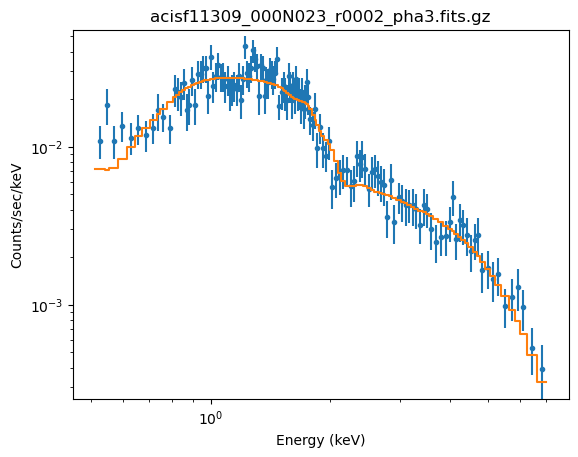

In [101]:
plot_fit(2, xlog=True, ylog=True)

We can see that the power-law slope is essentially identical to that I got earlier, as is the best-fit statistic (that is, the use of `xscflux` hasn't significantly changed the fit results):

In [102]:
print(pl.gamma.val)
print(pl2.gamma.val)

print('---')
print(calc_stat(1))
print(calc_stat(2))

1.7249402348363843
1.7249288201709716
---
115.73695966680434
115.73695963927764


The flux (in this case it is an energy flux) can be calculated directly from the model:

In [103]:
eflux = 10**(cmdl.lg10flux.val)
print(f"energy flux = {eflux:.4e} erg/cm^2/s")

energy flux = 5.6689e-13 erg/cm^2/s


We can get an error using
[covar](https://cxc.cfa.harvard.edu/sherpa/ahelp/covariance.html)
(or 
[conf](https://cxc.cfa.harvard.edu/sherpa/ahelp/confidence.html) but
that takes longer to run):

In [104]:
covar(2)

Dataset               = 2
Confidence Method     = covariance
Iterative Fit Method  = None
Fitting Method        = levmar
Statistic             = chi2datavar
covariance 1-sigma (68.2689%) bounds:
   Param            Best-Fit  Lower Bound  Upper Bound
   -----            --------  -----------  -----------
   cmdl.lg10Flux     -12.2465  -0.00999576   0.00999576
   pl2.gamma         1.72493   -0.0377149    0.0377149


In [105]:
errs = get_covar_results()
errs

<covariance results instance>

I can now compare the `sample_flux` results from above, namely:

In [106]:
print("\n# sample_flux (unabsorbed)")
xs = ures[1] * 1e13
print(f"Median = {xs[0]:.4f}      * 1e-13 erg/cm^2/s")
print(f"    {xs[2]:.4f} - {xs[1]:.4f}  * 1e-13 erg/cm^2/s")


# sample_flux (unabsorbed)
Median = 5.6732      * 1e-13 erg/cm^2/s
    5.5496 - 5.8019  * 1e-13 erg/cm^2/s


to the `cflux` results:

In [107]:
lflux = errs.parvals[0]
lsig = lflux + errs.parmins[0]
usig = lflux + errs.parmaxes[0]

xs = 10**np.asarray([lflux, usig, lsig]) * 1e13

print("# cflux")
print(f"Best fit = {xs[0]:.4f}    * 1e-13 erg/cm^2/s")
print(f"    {xs[2]:.4f} - {xs[1]:.4f}  * 1e-13 erg/cm^2/s")

# cflux
Best fit = 5.6689    * 1e-13 erg/cm^2/s
    5.5399 - 5.8009  * 1e-13 erg/cm^2/s


There is also the
[xscpflux](https://cxc.cfa.harvard.edu/sherpa/ahelp/xscpflux.html) 
model for if you want to calculate
the photon flux, and the
[xsclumin](https://cxc.cfa.harvard.edu/sherpa/ahelp/xsclumin.html)
and
[xscglumin](https://cxc.cfa.harvard.edu/sherpa/ahelp/xscglumin.html)
(new in CIAO 4.16)
models for calculating the luminosity, although I suggest doing 
the flux-to-luminosity calculation yourself taking advantage
of the 
[AstroPy cosmology module](https://astropy.readthedocs.io/en/stable/cosmology/index.html),
as discussed below.

## 7. Calculating luminosities

The following section is only relevant for "properly" 
extragalactic objects, that is those objects for which you need to worry about luminosity distances and k corrections.

### 7.1 The K correction

The [K correction](https://en.wikipedia.org/wiki/K_correction)
is used to account for the fact that the observed and rest-frame
pass bands are not the same. For simple models (such as a power-law)
it can be calculated analytically, but in general we will not be so lucky. Although it can be calculated manually (using the same
techniques as you would use to calculate the flux manually),
Sherpa provides the
[calc_kcorr](https://cxc.cfa.harvard.edu/sherpa/ahelp/calc_kcorr.html)
function. The following section just shows how to call this routine,
as there's much-more information provided in the
[Calculating K-corrections using Sherpa](https://cxc.cfa.harvard.edu/sherpa/threads/calc_kcorr/)
thread, which should be reviewed by the interested reader (particularly for models which contain a redshift parameter,
as this needs to be handled carefully when used with `calc_kcorr`).

For this example I am going to assume the source is at a redshift of 0.4, and that I want the flux in the rest-frame 0.5 to 7 keV:

In [108]:
dataspace1d(0.1, 20, 0.01, id='kcorr')
set_source('kcorr', pl)

kz = calc_kcorr(z=0.4, obslo=0.5, obshi=7, id='kcorr')
print("k correction = {:.4f}".format(kz))

k correction = 0.9116


### 7.2 luminosity distance

So, how do we go about using the 
[AstroPy cosmology module](https://astropy.readthedocs.io/en/stable/cosmology/index.html)
then? For this example I'm going to use the `Planck15` cosmology -
but there are
[a number of pre-defined cosmologies](https://astropy.readthedocs.io/en/stable/cosmology/index.html#built-in-cosmologies)
I could have picked from (or created one myself):

In [109]:
from astropy.cosmology import Planck15

This step does require that you have installed AstroPy and SciPy into your CIAO installation. For `conda` users this can be done with

    conda install astropy scipy
    
and for people whose CIAO was installed with `ciao-install`

    pip install astropy scipy
    
should also work.

**NOTE** it is possible that installing packages into CIAO could install an incompatible version of a library, so please be careful (and we recommend that you keep a copy of the install files if you used `ciao-install` so that you can re-create your CIAO installation in case of problems).

With a cosmology, we can now calculate the luminosity distance to our source (using my ficticious redshift of 0.4).

In [110]:
dl = Planck15.luminosity_distance(0.4)
print(dl)

2238.899726847312 Mpc


### 7.3 Putting it all together

Taking advantage of the 
[support for units](https://docs.astropy.org/en/latest/units/index.html) in AstroPy, let's take the median unabsorbed flux calculated by `sample_flux` and give it its units, then use it to calculate the rest-frame 0.5 to 7 keV luminosity for the source:

In [111]:
import astropy.units as u

obs_flux = ures[1][0] * u.erg / u.cm / u.cm / u.s

lumin = 4 * np.pi * dl * dl * obs_flux * kz

There is special code to display the units "nicely" in a Python notebook:

In [112]:
lumin

<Quantity 3.25775538e-05 Mpc2 erg / (s cm2)>

or we can print it out normally:

In [113]:
print(lumin)

3.2577553753537873e-05 Mpc2 erg / (s cm2)


Unfortunately this is not the friendly version (I tend to use erg/s) so can we simplify this? We can use the `decompose` method, which returns a value in units of Watts (although split into its fundamental components):

In [114]:
lumin.decompose()

<Quantity 3.1018412e+37 m2 kg / s3>

Instead, we can use `to` and tell it the units we want:

In [115]:
lumin.to(u.erg / u.s)

<Quantity 3.1018412e+44 erg / s>

---